In [1]:
from membrane_model_revise import *
import numpy as np
import matplotlib.pyplot as plt
'''
parameters = {'axes.labelsize': 17,
              'xtick.labelsize': 16,
              'ytick.labelsize': 16,
          'axes.titlesize': 20}
plt.rcParams.update(parameters)
plt.rcParams['font.family'] = 'arial'
'''
from itertools import product

# Membrane process simulation

In [2]:
# Sizing parameters
D_inner = 200*1e-3            # Membrane inner diameter (mm)
D_outer = 250*1e-3            # Membrane outer diameter (mm)
D_module = 0.1*1e3            # Module diameter (mm)
N_fiber = 60000               # number of fiber (-)
L = 0.6*1e3                   # fiber length (mm)
N = 400
n_component = 2

# Membrane module definition
mem = Membrane(L, D_inner, D_outer, D_module, N_fiber, 
            n_component, N_node = N)
print(mem)

[[Current information included here]] 
Design          : True
membrane_info   : False
gas_prop_info   : False
mass_trans_info : False
boundaryC_info  : False
initialC_info   : False



In [3]:
a_perm = np.array([3.207e-9, 1.33e-10])*1e-6*1e5 #Permeance(mol/(mm2 bar s))

# Membrane property setting
mem.membrane_info(a_perm)
print(mem)

[[Current information included here]] 
Design          : True
membrane_info   : True
gas_prop_info   : False
mass_trans_info : False
boundaryC_info  : False
initialC_info   : False



In [4]:
# Gas properties 
Mw_i = np.array([44e-3, 16e-3])     # Molar weight (kg/mol)
rho_i = np.array([1.98, 0.657])*1e-9     # Density (kg/mm3)
mu_H2 = 0.0155e-3           # H2 viscosity (Pa s)
mu_N2 = 0.011e-3           # N2 viscosity (Pa s)
mu_i = np.array([mu_H2, mu_N2])

# Gas property setting
mem.gas_prop_info(Mw_i, mu_i, rho_i)
print(mem)

[[Current information included here]] 
Design          : True
membrane_info   : True
gas_prop_info   : True
mass_trans_info : False
boundaryC_info  : False
initialC_info   : False



In [5]:
k_mass = 1e-1               # Mass transfer coeff. (mm/s)

# Mass transfer coefficient setting
mem.mass_trans_info(k_mass)
print(mem)

[[Current information included here]] 
Design          : True
membrane_info   : True
gas_prop_info   : True
mass_trans_info : True
boundaryC_info  : False
initialC_info   : False



In [6]:
# Operating conditions
P_feed = 60                # pressure of feed side (bar)
T = 296.15
F_feed = 0.175
y_feed = np.array([0.1, 0.9])     # mole fraction (CO2, CH4)
Ff_z0_init = list(y_feed*F_feed)

# Boundary condition setting
mem.boundaryC_info(P_feed, T, y_feed, Ff_z0_init)
print(mem)

[[Current information included here]] 
Design          : True
membrane_info   : True
gas_prop_info   : True
mass_trans_info : True
boundaryC_info  : True
initialC_info   : False



In [7]:
# Initial condition setting
mem.initialC_info('co')
print(mem)

[[Current information included here]] 
Design          : True
membrane_info   : True
gas_prop_info   : True
mass_trans_info : True
boundaryC_info  : True
initialC_info   : True



In [8]:
n_stg = 1
mode = 'P2F'

# Simulation run
res = mem.run_mem(n_stg, mode,)

In [9]:
# Error calculation
err = mem.MassBalance()
print(err)

Mass balance (error %):  0.0
0.0


In [10]:
# Economic analysis parameters
MODP = 10/1000000       # Total membrane module cost (US$/ft2)
mem_life = 4           # membrane life (years)
t = 5              # project year
r = 0.1             # interest rate (%)
k = 1.4       # Heat capacity ratio
effi_ref = 0.8     # compressor efficiency

# Economic analysis
sep_cost = mem.GRC(MODP,mem_life, t, r ,k,effi_ref )
print(np.round(sep_cost,2), '$/yr')

7643.14 $/yr


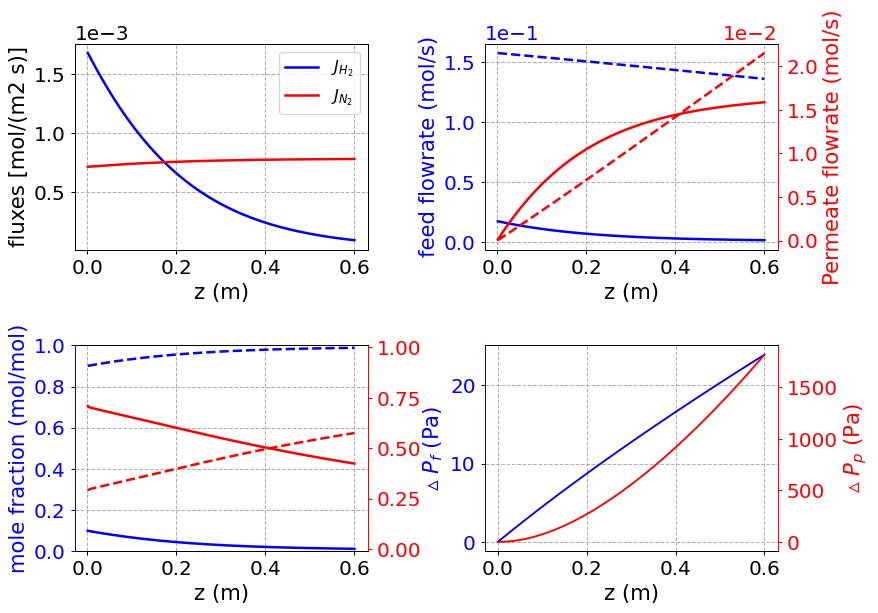

In [11]:
# Internal profile fiugre
mem.results_plot_kci_co()

# Sensitivity analysis

## Basis: Feed pressure

In [41]:
# Sensitivity analysis
P_dom = np.linspace(5,60,26)
raw_res = []
cost_list = []
for p_feed in P_dom:
    mem.boundaryC_info(p_feed, T, y_feed, Ff_z0_init)
    mem.initialC_info('co')
    res = mem.run_mem(n_stg, mode,)
    raw_res.append(res)
    cost_list.append(mem.GRC(MODP,mem_life, t, r ,k,effi_ref))

In [43]:
res_list = []
for res in raw_res:
    # CH4 purity in permeate and retentate side
    pu_list_p = [res[-1,3]/np.sum(res[-1,2:4])*100]
    pu_list_r = [res[-1,1]/np.sum(res[-1,:2])*100]
    
    # CH4 recovery in permeate and retentate side
    re_list_p = [res[-1,3]/(res[0,1]+res[0,3])*100]
    re_list_r = [res[-1,1]/(res[0,1]+res[0,3])*100]
    res_tmp = pu_list_p+pu_list_r+re_list_p+re_list_r
    res_list.append(res_tmp)

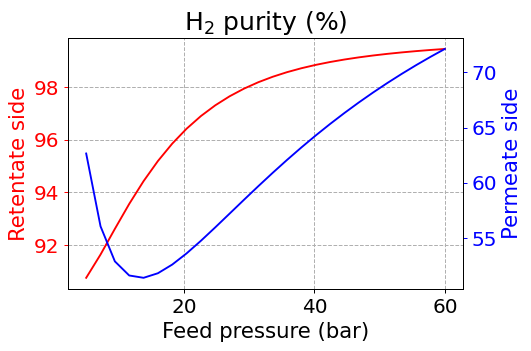

In [47]:
res_nd = np.array(res_list)
fig, ax1 = plt.subplots(dpi=90, figsize=(6,4))
ax2 = ax1.twinx()
ax1.plot(P_dom, res_nd[:,1], label='Retentate', c='r')
ax1.set_ylabel('Retentate side', color = 'red',)
ax1.grid(linestyle = '--')
ax2.plot(P_dom, res_nd[:,0], label='Permeate', c='b')
ax2.set_ylabel('Permeate side', color = 'b',)

ax1.spines["right"].set_edgecolor('r')
ax1.spines["left"].set_edgecolor('b')
ax2.tick_params(axis='y', colors='b')
ax1.tick_params(axis='y', colors='r')
            
plt.title('H$_2$ purity (%)')
ax1.set_xlabel('Feed pressure (bar)')
plt.tight_layout()
plt.show()

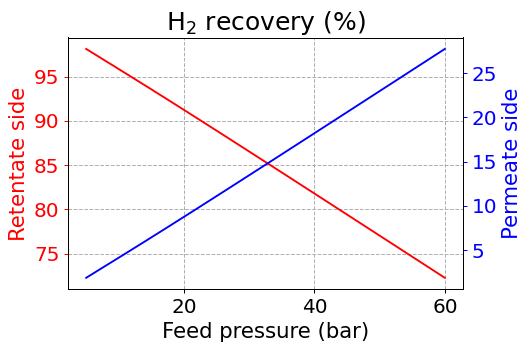

In [48]:
res_nd = np.array(res_list)
fig, ax1 = plt.subplots(dpi=90, figsize=(6,4))
ax2 = ax1.twinx()
ax1.plot(P_dom, res_nd[:,3], label='Retentate', c='r')
ax1.set_ylabel('Retentate side', color = 'red',)
ax1.grid(linestyle = '--')

ax2.plot(P_dom, res_nd[:,2], label='Permeate', c='b')
ax2.set_ylabel('Permeate side', color = 'b',)

ax1.spines["right"].set_edgecolor('r')
ax1.spines["left"].set_edgecolor('b')
ax2.tick_params(axis='y', colors='b')
ax1.tick_params(axis='y', colors='r')
            
plt.title('H$_2$ recovery (%)')
ax1.set_xlabel('Feed pressure (bar)')
plt.tight_layout()
plt.show()

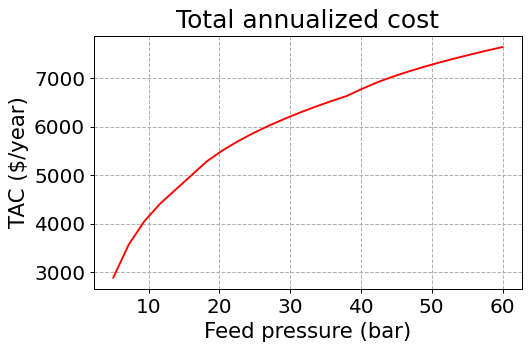

In [49]:
res_nd = np.array(res_list)
fig, ax1 = plt.subplots(dpi=90, figsize=(6,4))
ax1.plot(P_dom, cost_list, label='Retentate', c='r')
ax1.set_ylabel('TAC ($/year)', color = 'k',)
ax1.set_xlabel('Feed pressure (bar)')
ax1.grid(linestyle = '--')
plt.title('Total annualized cost')
plt.tight_layout()
plt.show()

## Basis: permeance

In [21]:
a_co2_max, a_co2_min = a_perm[0]*2, a_perm[0]*0.5
a_ch4_max, a_ch4_min = a_perm[1]*2, a_perm[1]*0.5

co2_dom = np.linspace(a_co2_min, a_co2_max,5)
ch4_dom = np.linspace(a_ch4_min, a_ch4_max,5)

a_dom = list(product(co2_dom, ch4_dom))

In [22]:
raw_res = []
for _a_perm in a_dom:
    mem.membrane_info(_a_perm)
    mem.boundaryC_info(P_feed, T, y_feed, Ff_z0_init)
    mem.initialC_info('co')
    res = mem.run_mem(n_stg, mode,)
    raw_res.append(res)

In [24]:
res_list = []
for res in raw_res:
    # CH4 purity in permeate and retentate side
    pu_list_p = [res[-1,3]/np.sum(res[-1,2:4])*100]
    pu_list_r = [res[-1,1]/np.sum(res[-1,:2])*100]
    
    # CH4 recovery in permeate and retentate side
    re_list_p = [res[-1,3]/(res[0,1]+res[0,3])*100]
    re_list_r = [res[-1,1]/(res[0,1]+res[0,3])*100]
    res_tmp = pu_list_p+pu_list_r+re_list_p+re_list_r
    res_list.append(res_tmp)

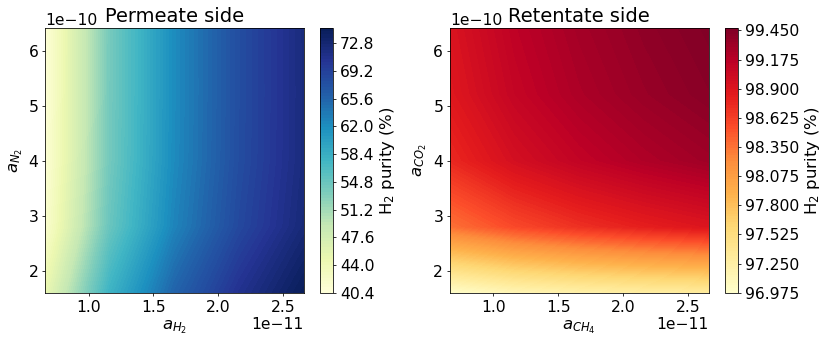

In [28]:
fig = plt.figure(figsize=(12,5),dpi=70)

ax1 = fig.add_subplot(121)
data = np.array(res_list)[:,0].reshape(5,5)
fig.set_facecolor('white')
cp = ax1.contourf(ch4_dom, co2_dom, data, cmap= 'YlGnBu', levels=100)
plt.colorbar(cp, label='H$_2$ purity (%)') # Add a colorbar to a plot
plt.title('Permeate side')
ax1.set_xlabel('$a_{H_2}$')
ax1.set_ylabel('$a_{N_2}$')

ax2 = fig.add_subplot(122)
data = np.array(res_list)[:,1].reshape(5,5)
fig.set_facecolor('white')
cp = ax2.contourf(ch4_dom, co2_dom, data, cmap= 'YlOrRd', levels=100)
plt.colorbar(cp, label='H$_2$ purity (%)') # Add a colorbar to a plot
plt.title('Retentate side')
ax2.set_xlabel('$a_{CH_4}$')
ax2.set_ylabel('$a_{CO_2}$')
plt.tight_layout()
plt.show()

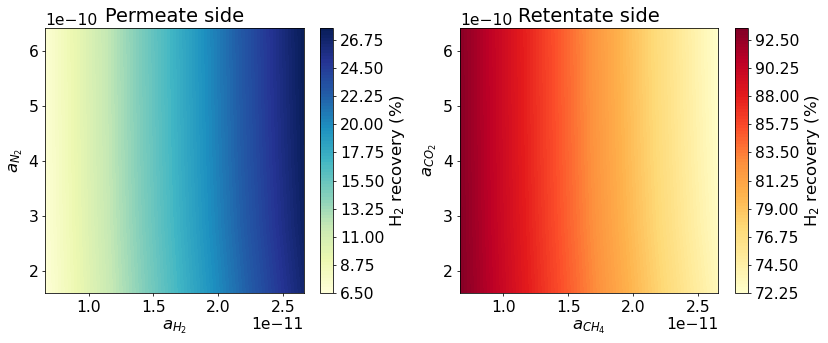

In [27]:
fig = plt.figure(figsize=(12,5),dpi=70)

ax1 = fig.add_subplot(121)
data = np.array(res_list)[:,2].reshape(5,5)
fig.set_facecolor('white')
cp = ax1.contourf(ch4_dom, co2_dom, data, cmap= 'YlGnBu', levels=100)
plt.colorbar(cp, label='H$_2$ recovery (%)') # Add a colorbar to a plot
plt.title('Permeate side')
ax1.set_xlabel('$a_{H_2}$')
ax1.set_ylabel('$a_{N_2}$')

ax2 = fig.add_subplot(122)
data = np.array(res_list)[:,3].reshape(5,5)
fig.set_facecolor('white')
cp = ax2.contourf(ch4_dom, co2_dom, data, cmap= 'YlOrRd', levels=100)
plt.colorbar(cp, label='H$_2$ recovery (%)') # Add a colorbar to a plot
plt.title('Retentate side')
ax2.set_xlabel('$a_{CH_4}$')
ax2.set_ylabel('$a_{CO_2}$')
plt.tight_layout()
plt.show()